## Stokes Flow in Periodic Channel with Robin boundary.

In [1]:
import sys
sys.path.append('/home/emastr/phd/')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"#"last_expr_or_assign"

import numpy as np
import matplotlib.pyplot as plt
from util.logger import EventTracker
from util.basis_scaled import *
from util.plot_tools import *
from boundary_solvers.gauss_grid_2d import StokesDirichletProblem
from scipy.io import loadmat
import matplotlib.pyplot as plt
from util.interp import PiecewiseInterp2D
from hmm.stokes import *
from hmm.stokes_deep import DeepMicroSolver, get_net
import matplotlib

matplotlib.rcParams['text.usetex'] = True

pretty_pyplot_layout()

## Multiscale Problem

We define a multiscale problem as follows. The PDE is a non-slip zero forcing Stokes flow Problem

\begin{equation}
\Delta u  - \nabla p = 0, \qquad \qquad \nabla \cdot u = 0   \qquad \text{inside}\quad \Omega
\end{equation}

with the boundary conditions

\begin{equation}
u = g,\qquad \text{on}\quad\partial\Omega
\end{equation}

the boundary is a two-dimensional pipe with corners at (0,-1) and (1,1), and a micro scale boundary:

In [2]:
i = 41 # 38 #41 #35 #11 #38 #22 
data, info = StokesData.load_from_matlab(f"/home/emastr/phd/data/reference_2/run_{i}.mat")
data_big_domain = data
dom = data.dom
eval_pos = info["eval_pos"]
eps = info["eps"]
nper = info["nper"]
Lx = info["Lx"]
bbox = info["bbox"]
Uc = info['Uc']
Vc = info['Vc']
Uyc = info['Uyc']

x = np.linspace(bbox[0][0],bbox[0][1],Uc.shape[0])
y = np.linspace(bbox[1][0],bbox[1][1],Uc.shape[1])
X,Y = np.meshgrid(x,y)

pwlerp = PiecewiseInterp2D(x, y, Uc)
pwlerp_dy = PiecewiseInterp2D(x, y, Uyc)
pwlerp_alpha = lambda x: -pwlerp(x, np.ones_like(x)*eval_pos) / pwlerp_dy(x, np.ones_like(x)*eval_pos)

### Load Network for evaluation

In [3]:
device = "cpu" # "cuda:0"
net, net_settings = get_net(f"/home/emastr/phd/data/runs/fnoskip_big_data_48_{40000}.Torch", 256, "cpu", "float")

## Coupling to Micro Domain

To couple the macro domain to the microscopic domain, we make use of the HMM framework.
We construct a set of evenly spaced micro problems based on the Stokes data. The macro problem is constructed with a pre-specified resolution in the x- and y-directions.

/tmp/ipykernel_127268/1590932164.py:54: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(X, Y, Uc, vmin=vmin, vmax=vmax)


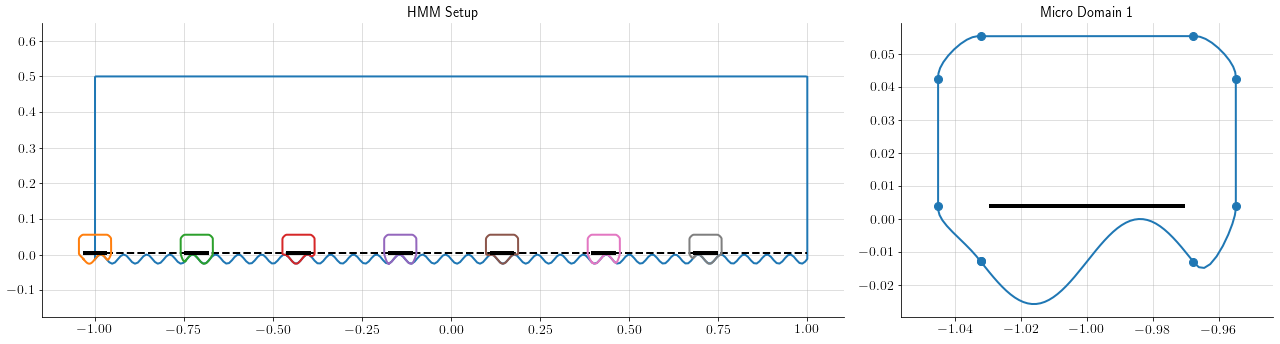

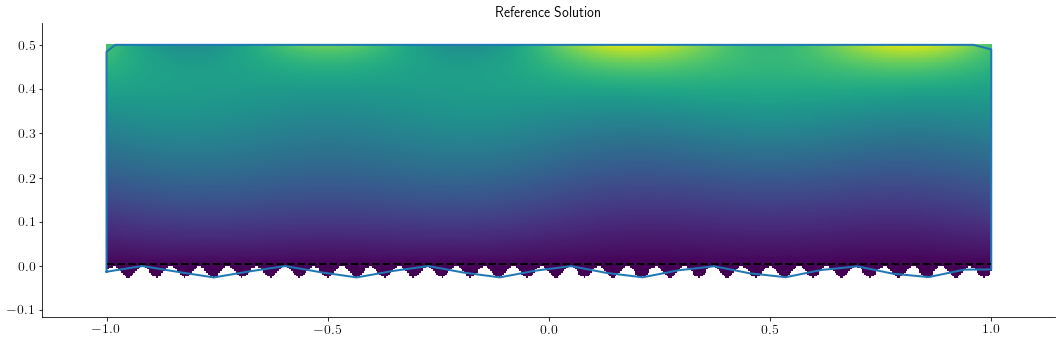

In [4]:
logger = EventTracker() # Log time

tol = 1e-10
#################
# Macro problem
#################

xDim = 21
yDim = 21
macro = StokesMacProb(data, lambda x,a: fft_interp(x, a, dom=dom[0]))
macro_0 = StokesMacProb(data, lambda x,a: fft_interp(x, a, dom=dom[0])) # For comparison
###################
# Micro problems
###################

nMic = 7 #freq_g*2+1#2*(round(Lx/(30*eps)) // 2) + 1 # 15 # 15 #nMic*2 +1
yDim_reduce=5
xDim_reduce=5
width= 5*eps #5*eps #3
height=width*0.8 #3
n_refine=0
#xPos = np.linspace(dom[0][0]+4*eps, dom[0][1]-4*eps, nMic)-2*eps
xPos = np.linspace(dom[0][0], dom[0][1], nMic+1)[1:] - width/2 - Lx / nMic/1
micros = [StokesMicProb(data, x, width, height, linePos=0.0, deg_project=8, logger=logger, 
                        n_refine=n_refine, xDim_reduce=xDim_reduce, yDim_reduce=yDim_reduce) for x in xPos]

###################
# Hmm problem.
conv_checker = ConvergenceChecker(macro, micros, tol=tol)
hmm_prob = StokesHMMProblem(macro, micros, data, convergence_checker=conv_checker)

###################
## PLOT ##
plt.figure(figsize=(18,5))


plt.subplot2grid((1, 3), (0, 0), 1, 2)
plt.title("HMM Setup")
hmm_prob.plot(plt.gca())
plt.axis("Equal")
remove_top_right_axes(plt.gca())

plt.subplot2grid((1, 3), (0, 2), 1, 1)
plt.title("Micro Domain 1")
micros[0].plot(plt.gca(), showsegments=True)
plt.axis("Equal")
remove_top_right_axes(plt.gca())

# Plot

vmin, vmax= 0, .7
plt.figure(figsize=(15,5))
plt.title("Reference Solution")
plt.pcolormesh(X, Y, Uc, vmin=vmin, vmax=vmax)
data.plot(plt.gca())
plt.axis("equal")
remove_top_right_axes(plt.gca())
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])



## Solving using HMM iterations

To solve the problem, we make use of a sequence of micro solvers, as well as a micro solver.

In [5]:
class Callback():
    def __init__(self, macro):
        self.N = 100
        self.x = np.linspace(0,1,self.N)
        self.macro = macro
        self.current_alpha = macro.alpha(self.x)
        self.diff = []
    
    def __call__(self, it, macro_sol, micro_sols):
        self.previous_alpha = self.current_alpha
        self.current_alpha = self.macro.alpha(self.x)
        self.diff.append(np.linalg.norm(self.previous_alpha - self.current_alpha) / self.N**0.5)
        
debug_cb = Callback(macro)



macro_solver = MacroSolver(xDim, yDim, tol=tol, logger=logger)

print("Deep precomputing...")
logger.start_event("Deep precomputing, total")
deep_micro_solvers = [DeepMicroSolver(m, net, net_settings, logger=logger, tol=tol) for m in micros]
logger.end_event("Deep precomputing, total")

class CountCallback():
    def __init__(self):
        self.count = 0
    def __call__(self, *args):
        self.count += 1
counters = [CountCallback() for m in micros]
    
print("Classic precomputing...")
logger.start_event("Classic precomputing, total")
micro_solvers = [MicroSolver(m, logger=logger, tol=100*tol, callback=c) for m, c in zip(micros, counters)]
logger.end_event("Classic precomputing, total")
print("Done")

deep_hmm_solver = IterativeHMMSolver(macro_solver, deep_micro_solvers)
hmm_solver = IterativeHMMSolver(macro_solver, micro_solvers)

print([c.count for c in counters])

Deep precomputing...
Classic precomputing...
Done
[20, 23, 19, 23, 19, 24, 19]


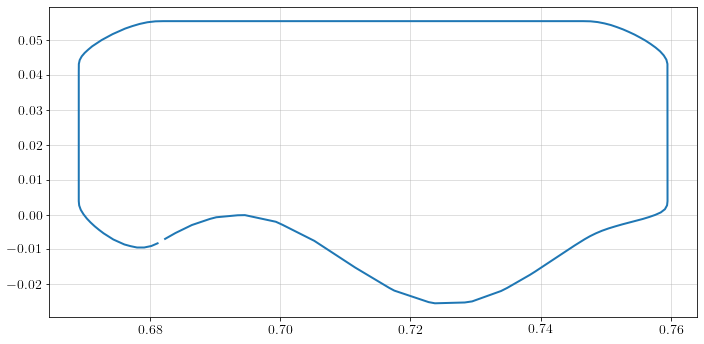

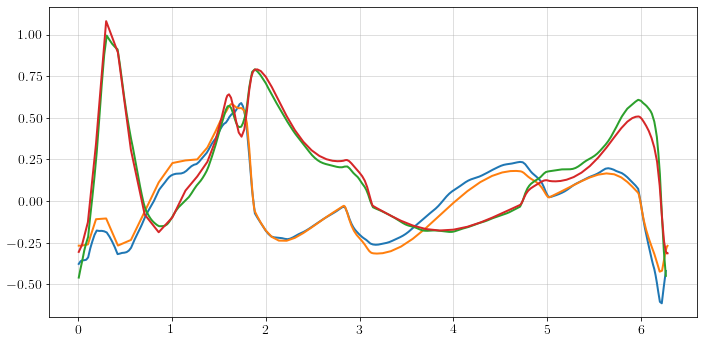

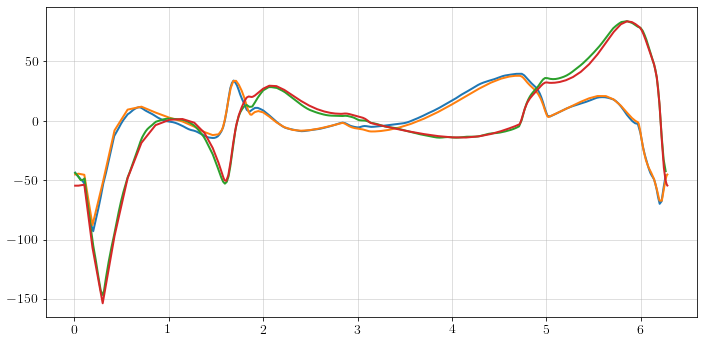

In [6]:
deep_micro_solvers[6].plot()

In [7]:
macro_guess = macro_solver.solve(macro)

print("Deep HMM Solver...")
logger.start_event("Deep HMM Solver, total")
(deep_macro_sol, deep_micro_sols) = deep_hmm_solver.solve(hmm_prob, macro_guess=macro_guess, 
                                           callback=debug_cb, verbose=True, maxiter=3, tol=tol, logger=logger)
logger.end_event("Deep HMM Solver, total")
print("\nDone")

deep_diff = debug_cb.diff
debug_cb.diff = []



print("Classic HMM Solver...")
logger.start_event("Classic HMM Solver, total")
(macro_sol, micro_sols) = hmm_solver.solve(hmm_prob, macro_guess=macro_guess, 
                                           callback=debug_cb, verbose=True, maxiter=3, tol=tol, logger=logger)
logger.end_event("Classic HMM Solver, total")
print("\nDone")





Deep HMM Solver...


Step 2/3
Done
Classic HMM Solver...
Step 2/3
Done


### Convergence and computation time

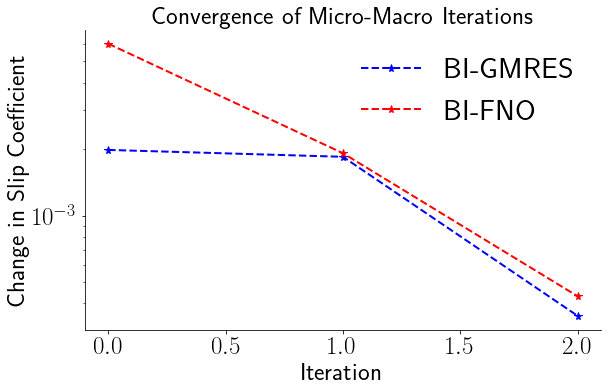

In [8]:
plt.figure(figsize=(9,6))
matplotlib.rcParams.update({'font.size': 25})

plt.title("Convergence of Micro-Macro Iterations")
plt.semilogy(debug_cb.diff, 'b*--', label='BI-GMRES')
plt.semilogy(deep_diff, 'r*--', label='BI-FNO')
plt.legend(loc='upper right', frameon=False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.grid(False)
plt.xlabel("Iteration")
plt.ylabel("Change in Slip Coefficient")
plt.gcf().savefig("/home/emastr/phd/data/figures_math4dl/convergence.pdf", bbox_inches='tight')


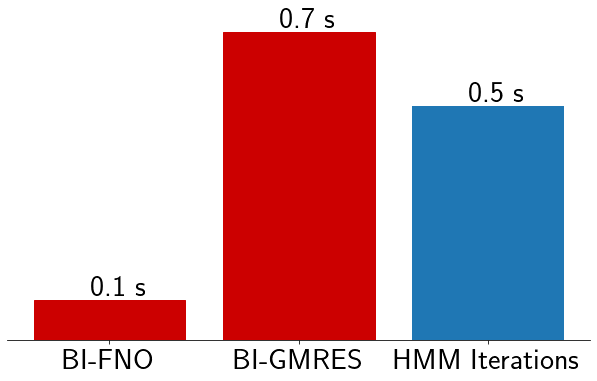

In [9]:
from util.logger import Event
matplotlib.rcParams.update({'font.size': 30})

plt.figure(figsize=(9,6))
events = [logger.events[name] for name in ['Deep precomputing, total', 'Classic precomputing, total', 'Classic HMM Solver, total']]
bars = plt.bar(['BI-FNO', 'BI-GMRES', 'HMM Iterations'], [e.time_mean for e in events])
for i, v in enumerate(events):
    plt.text(i-0.1, v.time_mean + 0.01, f"{v.time_mean:.1f} s", size=30)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.yticks([])
    
[bars[i].set_color([0.8, 0, 0]) for i in [0,1]]
plt.gcf().savefig("/home/emastr/phd/data/figures_math4dl/times.pdf", bbox_inches="tight")



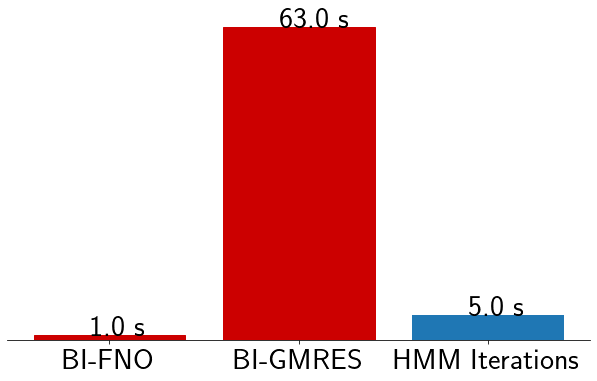

In [14]:
from util.logger import Event
matplotlib.rcParams.update({'font.size': 30})

plt.figure(figsize=(9,6))
events = [logger.events[name] for name in ['Deep precomputing, total', 'Classic precomputing, total', 'Classic HMM Solver, total']]
times = [1, 63, 5]
bars = plt.bar(['BI-FNO', 'BI-GMRES', 'HMM Iterations'], times)
for i, v in enumerate(events):
    plt.text(i-0.1, times[i] + 0.01, f"{times[i]:.1f} s", size=30)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.yticks([])
    
[bars[i].set_color([0.8, 0, 0]) for i in [0,1]]
plt.gcf().savefig("/home/emastr/phd/data/figures_iciam/times.pdf", bbox_inches="tight")



## Accuracy
We use the reference solver data to construct a piecewise linear interpolation. Also, the micro data is used to construct a set of full solutions to the velocity field in the micro problems for visualisation purposes.

In [68]:
def plot_line_2(xval, yval, funcs, titles, styles, domain_plotter=None, axis='x'):

    

    if axis=='x':
        xplot = xval
    else:
        xplot = yval

    # Solution
    plt.figure(figsize=(8,5))
    plt.title("Solution on line", size=25)
    plt.grid(False)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    func_vals = [f(xval, yval) for f in funcs]
    for title, val, stl in zip(titles, func_vals, styles):
        plt.plot(xplot, val, stl, label=title)
    remove_top_right_axes(plt.gca())
    plt.legend(frameon=False)
    plt.gcf().savefig(f"/home/emastr/phd/data/figures_math4dl/line_{axis}.pdf", bbox_inches='tight')
    
    # Errors
    plt.figure(figsize=(8,5))
    plt.title("Error on line", size=25)
    plt.grid(False)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    for title, val, stl in zip(titles[1:], func_vals[1:], styles[1:]):
        plt.plot(xplot, val - func_vals[0], stl, label=title)
    remove_top_right_axes(plt.gca())
    plt.legend(frameon=False)
    plt.gcf().savefig(f"/home/emastr/phd/data/figures_math4dl/line_error_{axis}.pdf", bbox_inches='tight')

    # Domain
    plt.figure(figsize=(8,5))
    plt.title("Evaluation Setup")
    if domain_plotter is not None:
        domain_plotter(plt.gca(), color='k')
    plt.plot(xval, yval, 'r--', linewidth=2, label="evaluation")
    plt.axis('off')
    plt.gcf().savefig(f"/home/emastr/phd/data/figures_math4dl/domain_{axis}.pdf", bbox_inches='tight')

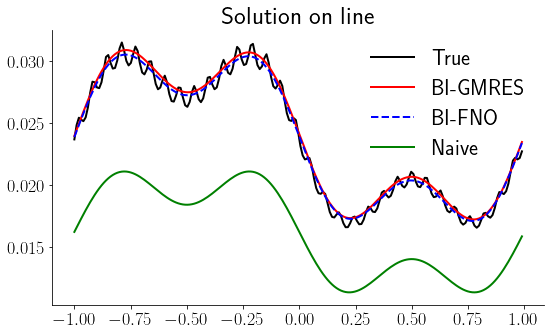

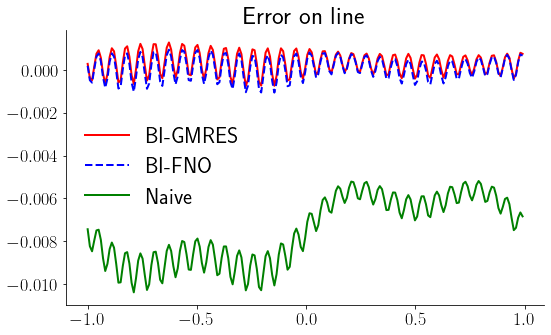

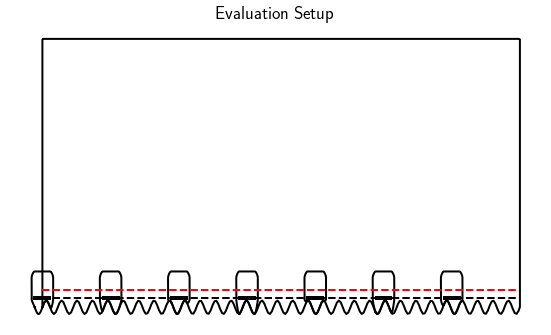

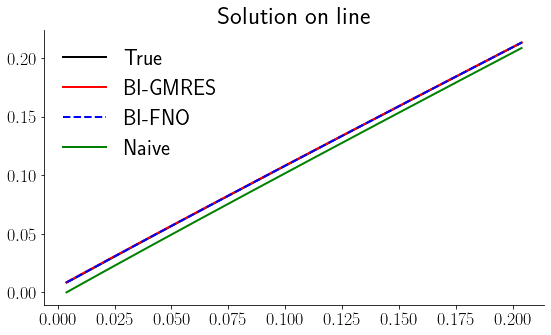

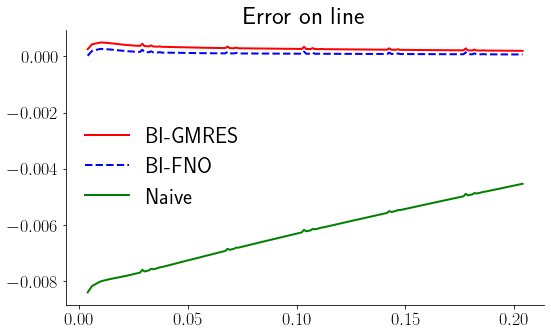

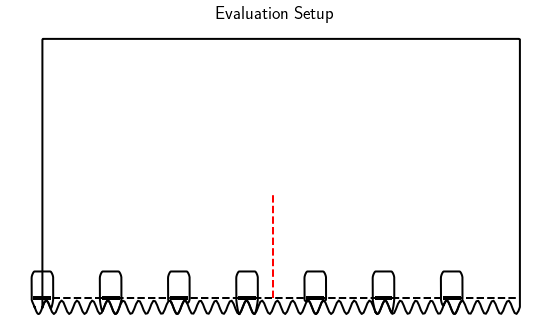

In [69]:
macro_guess = macro_solver.solve(macro_0)
matplotlib.rcParams.update({'font.size': 18})

# plot a line at y = 0.03
xval = np.linspace(dom[0][0],dom[0][1], 200)[:-1]
yval = np.ones_like(xval)*0.02
basis = ScaleShiftedBasis.fromFunctionInDomain(lambda x: pwlerp(x,yval), dom[0], FourBasis, dim=len(yval)).change_dim(nMic*2+1)
smooth = lambda x, y: basis(x)
funcs = [pwlerp, macro_sol.u, deep_macro_sol.u, macro_guess.u]
title = [ "True", "BI-GMRES", "BI-FNO", "Naive"]
styles = ['k-', 'r-', 'b--', 'g-']
# Plot solutions on horizontal line
plot_line_2(xval, yval, funcs, title, styles, hmm_prob.plot, axis='x')

# plot a vertical line in between the first and second micro problems
yval = np.linspace(dom[1][0], dom[1][0] + 0.2, 200)
xval = 0.5*(xPos[nMic//2] + xPos[nMic//2+1]) * np.ones_like(yval)
plot_line_2(xval, yval, funcs, title, styles, hmm_prob.plot, axis='y')

## Visualisation - 2D plots

/tmp/ipykernel_120439/3928450057.py:24: RuntimeWarning: invalid value encountered in true_divide
  return np.where(np.abs(omega)<1e-3, np.ones_like(omega), np.sin(omega * a) / (omega * a))
/home/emastr/anaconda3/envs/pimlenv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


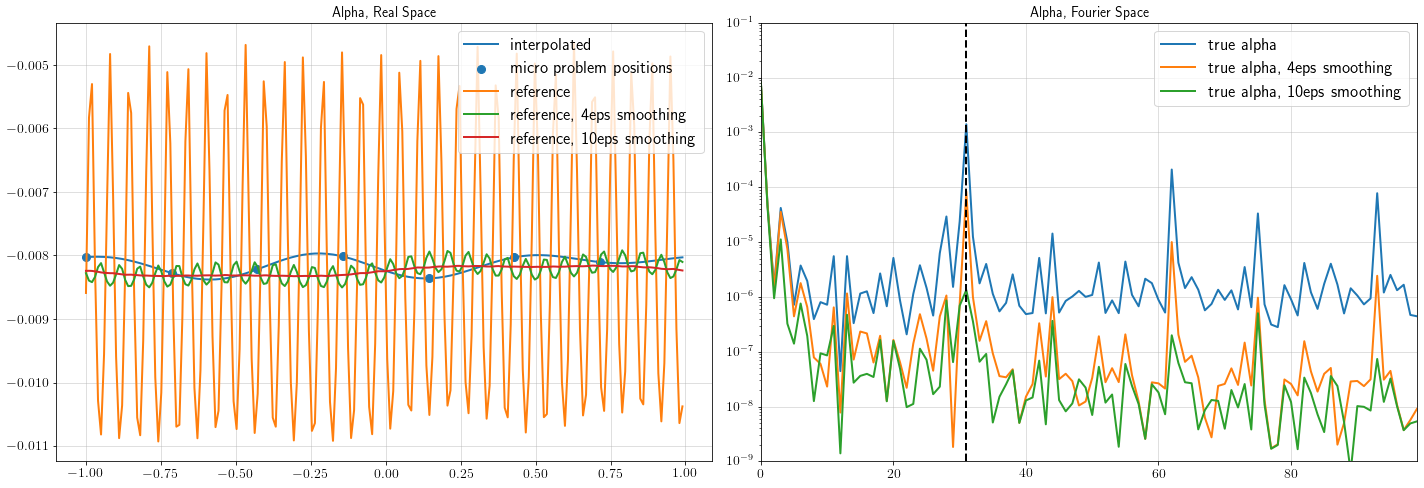

In [24]:
pwlerp_alpha = lambda x: -pwlerp(x, np.ones_like(x)*eval_pos) / pwlerp_dy(x, np.ones_like(x)*eval_pos)
pwlerp_alpha_2 = lambda x: -pwlerp(x, np.ones_like(x)*0.05) / pwlerp_dy(x, np.ones_like(x)*0.05)


x = np.linspace(dom[0][0],dom[0][1],200)[:-1]
a = macro.alpha(x)
xm = np.array([sol.x for sol in micro_sols])
am = np.array([sol.alpha for sol in micro_sols])

# Estimating alpha
dy = 0.01
y = 0.045*np.ones_like(x)
#a_apx = eval_pos/0.045/10*(pwlerp(x, y+dy)-pwlerp(x, y))/(pwlerp(x, y))-0.01
#_apx = np.sin(x * np.pi * 2)

a_apx = pwlerp_alpha(x)

basis = FourBasis(FourBasis._interpolate(pwlerp_alpha(x)))
freq = np.imag(basis._freq(basis.dim))
ks = freq / (2 * np.pi)
coef = basis.get_coef()

def sq_filt(omega, a):
    return np.where(np.abs(omega)<1e-3, np.ones_like(omega), np.sin(omega * a) / (omega * a))
filt = lambda a: sq_filt(freq, a)
filtered1 = filt(4*eps) * coef
filtered2 = filt(10*eps) * coef

scale, shift  = ScaleShiftedBasis._domain_to_scale_shift(FourBasis._domain(), dom[0])
filtered1_inv = ScaleShiftedBasis(FourBasis(filtered1), scale, shift)
filtered2_inv = ScaleShiftedBasis(FourBasis(filtered2), scale, shift)
truncated_inv = filtered1_inv.change_dim(nMic)

plt.figure(figsize=(20,7))

plt.subplot(121)
plt.title("Alpha, Real Space")
plt.plot(x, a, label="interpolated")
plt.scatter(xm, am, label="micro problem positions")
plt.plot(x, a_apx, label="reference")
filtered1_inv.plot(plt.gca(), dim=200, label="reference, 4eps smoothing")
filtered2_inv.plot(plt.gca(), dim=200, label="reference, 10eps smoothing")
plt.legend()

plt.subplot(122)
plt.title("Alpha, Fourier Space")
plt.semilogy(ks, np.abs(coef), label="true alpha")
#plt.semilogy(freq, filt(eps) * coef)
plt.semilogy(ks, np.abs(filtered1), label="true alpha, 4eps smoothing")

plt.semilogy(ks, np.abs(filtered2), label="true alpha, 10eps smoothing")
# plot vertical lines at frequencies corresponding to eps
plt.plot([nper, nper], [1e-9, 1e-1], 'k--')
plt.legend()
plt.ylim([1e-9, 1e-1])
plt.xlim([0, max(ks)])

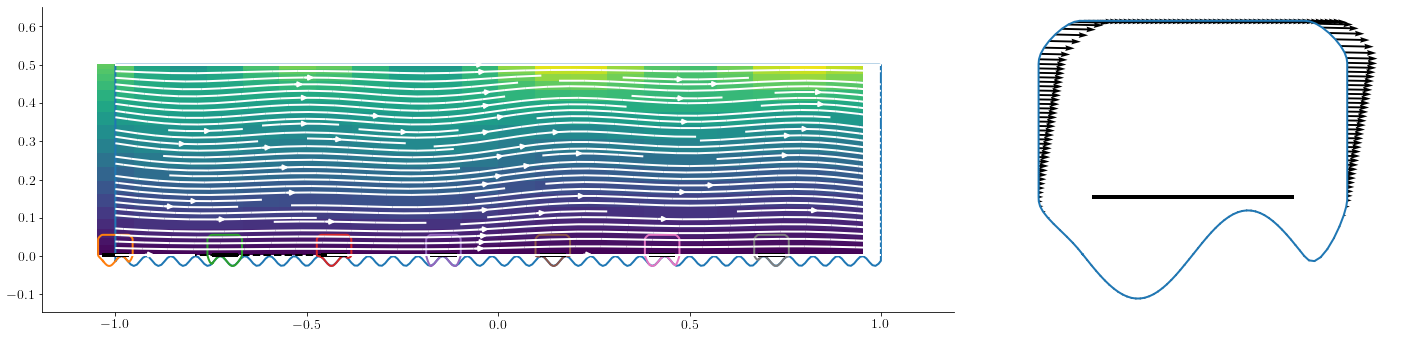

In [25]:
from util.basis_scaled import ScaleShiftedBasis
plt.figure(figsize=(20,5))

plt.subplot2grid((1, 3), (0, 0), 1, 2)
plt.axis("equal")
hmm_prob.plot(plt.gca())
macro_sol.u.plot(plt.gca())
macro_sol.plot_stream(plt.gca(), color="white")
w = dom[0][1] - dom[0][0]
plt.xlim([dom[0][0]-0.1*w, dom[0][1]+0.1*w])
plt.ylim([dom[1][0]-0.1*w, dom[1][1]+0.1*w])
remove_top_right_axes(plt.gca())

plt.subplot2grid((1, 3), (0, 2), 1, 1)
micros[0].plot(plt.gca())
micros[0].geom.plot_field_on_boundary(plt.gca(), micros[0].condition)
plt.axis("equal")
remove_axes(plt.gca())

/tmp/ipykernel_120439/4096828511.py:19: RuntimeWarning: invalid value encountered in true_divide
  return np.where(np.abs(omega)<1e-3, np.ones_like(omega), np.sin(omega * a) / (omega * a))


/tmp/ipykernel_120439/4096828511.py:46: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


RuntimeError: latex was not able to process the following string:
b'# micro domains'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../599c5ea6ab46f6451a67d7c13f5f6d13.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 84 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
No file 599c5ea6ab46f6451a67d7c13f5f6d13.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in vertical mode.
l.18 {\sffamily #
                  micro domains}
No pages of output.
Transcript written on 599c5ea6ab46f6451a67d7c13f5f6d13.log.




<Figure size 720x360 with 2 Axes>

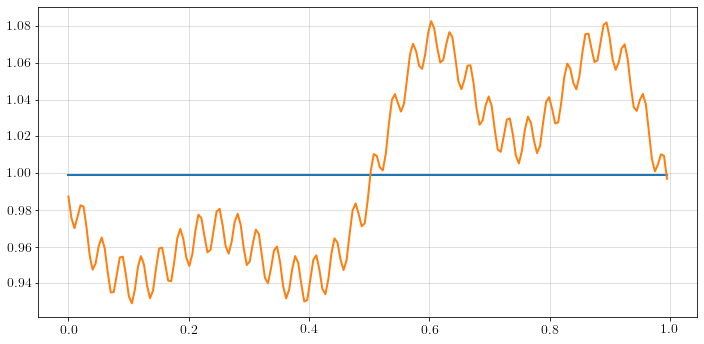

In [26]:
from util.basis_scaled import ScaleShiftedBasis

x = np.linspace(dom[0][0],dom[0][1],401)
a = macro.alpha(x)
xm = np.array([sol.x for sol in micro_sols])
am = np.array([sol.alpha for sol in micro_sols])

# Estimating alpha
dy = 0.01
y = 0.045*np.ones_like(x)
a_apx = (pwlerp(x, y+dy)-pwlerp(x, y))/pwlerp(x, y)
a_apx = a_apx / np.mean(a_apx**2)**0.5

basis = FourBasis(FourBasis._interpolate(a_apx))
freq = np.imag(basis._freq(basis.dim))
coef = basis.get_coef()

def sq_filt(omega, a):
    return np.where(np.abs(omega)<1e-3, np.ones_like(omega), np.sin(omega * a) / (omega * a))
filt = lambda a: sq_filt(freq, a)

hs = np.logspace(-5, 1, 10)
#hs = np.linspace(0.1, 4, 10)
dims = np.array([2 * m + 1 for m in range(0, 20)])
mse = []
for d in dims:
    mse_sub = []
    for h in hs:
        filtered = filt(h) * coef
        filt_basis = FourBasis(filtered)
        trunc = filt_basis.change_dim(d).change_dim(basis.dim)
        mse_sub.append(np.mean(np.abs((trunc - basis).eval_grid())**2))
        #mse_sub.append(np.mean(np.abs(trunc.coef - basis.coef)**2))
    mse.append(mse_sub)
H, D = np.meshgrid(hs, dims)
logH = np.log(H)
c = 0.001
c2 = 11
hbig = np.logspace(-5, 1, 100)

plt.figure()
#plt.pcolormesh(logH, D, np.log10(np.array(mse))) # + c * H * D
plt.imshow(np.log10(np.array(mse))) # + c * H * D
#plt.plot(np.log(hbig), c2/(hbig+1)-1, 'red')
plt.plot(np.log(hbig), c2/(hbig+1)-1, 'red')
plt.colorbar()
plt.xlabel("log(micro domain width)")
plt.ylabel("# micro domains")

plt.figure()
trunc.plot(plt.gca(), 200)
basis.plot(plt.gca(), 200)

In [ ]:
xhd = np.linspace(dom[0][0],dom[0][1], Nx)
yhd = np.linspace(dom[1][0]-0.1,dom[1][1], Ny)
Xhd, Yhd = np.meshgrid(xhd, yhd)
Uhd = pwlerp(Xhd.flatten(),Yhd.flatten()).reshape((Ny, Nx))

full_micro_sols = []
for it, m in enumerate(micros):
    prob = StokesDirichletProblem(m.geom, m.condition)
    print(f"solving {it}/{len(micros)}", end="\r")
    prob.solve(verbose=False)
    full_micro_sols.append(prob)

NameError: name 'Nx' is not defined

/tmp/ipykernel_37052/2334165283.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(Xhd, Yhd, Uhd, vmin=vmin, vmax=vmax)#, vmin=0, vmax=0.003)#, vmin=-0.5, vmax=0.5)#, vmin=-0.5, vmax=0.5)
/home/emastr/phd/util/interp.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return (w1 * z0[0] + w2 * z0[1] + w3 * z0[2] + w4 * z0[3]) / (w1 + w2 + w3 + w4)


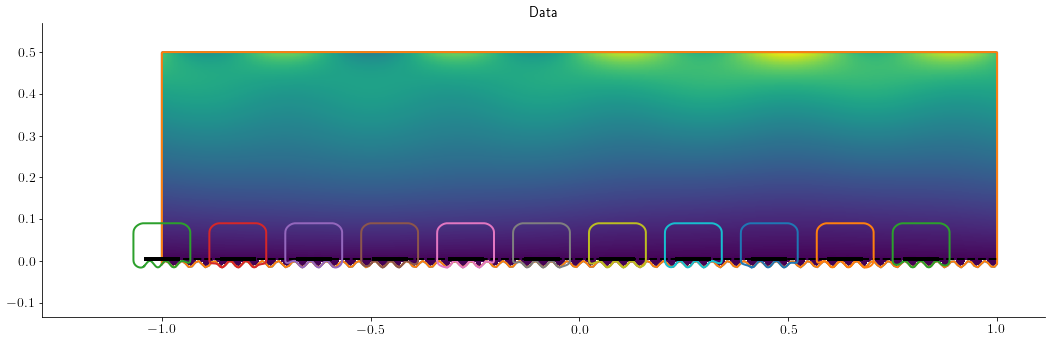

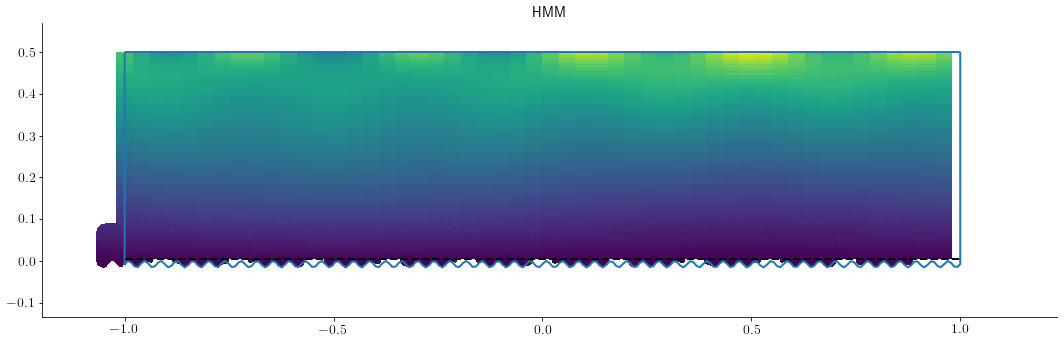

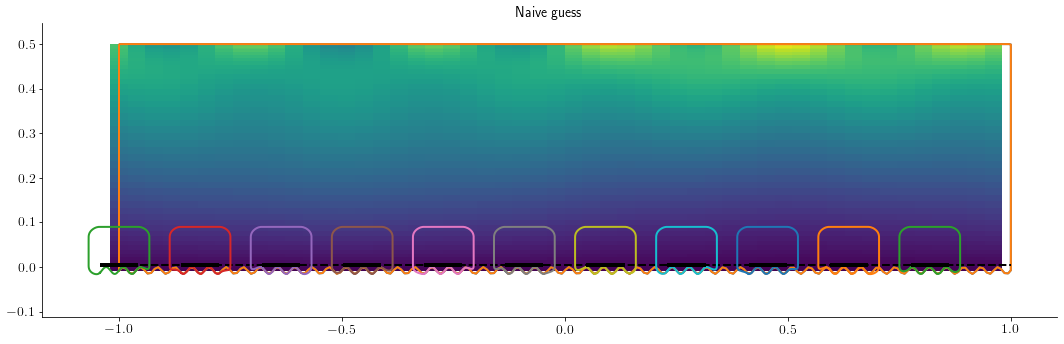

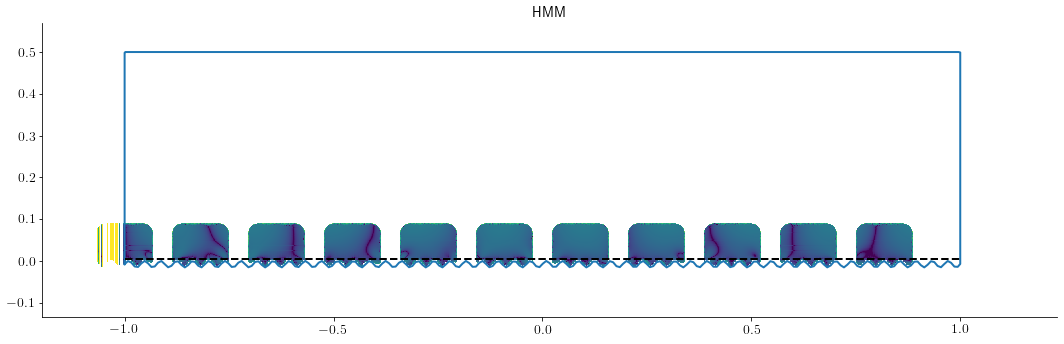

In [ ]:


vmax, vmin = 0.7, 0.

plt.figure(figsize=(15,5))
plt.title("Data")
plt.pcolormesh(Xhd, Yhd, Uhd, vmin=vmin, vmax=vmax)#, vmin=0, vmax=0.003)#, vmin=-0.5, vmax=0.5)#, vmin=-0.5, vmax=0.5)
data.plot(plt.gca())
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.axis("equal")
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])
hmm_prob.plot(plt.gca())

plt.figure(figsize=(15,5))
plt.title("HMM")
macro_sol.u.plot(plt.gca(), vmin=vmin, vmax=vmax)
data.plot(plt.gca())
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.axis("equal")
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])
for m, s in zip(micros, full_micro_sols):
    m.geom.plot_field(plt.gca(), lambda z: np.real(s.evaluate(z)), apply_mask=True, vmin=vmin, vmax=vmax)
#hmm_prob.plot(plt.gca(), color='black', linewidth=1)



plt.figure(figsize=(15,5))
plt.title("Naive guess")
macro_guess.u.plot(plt.gca(), vmin=vmin, vmax=vmax)
data.plot(plt.gca())
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.axis("equal")
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])
hmm_prob.plot(plt.gca(), color='black', linewidth=1)



plt.figure(figsize=(15,5))
plt.title("HMM")
#macro_sol.u.plot(plt.gca(), vmin=vmin, vmax=vmax)
data.plot(plt.gca())
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.axis("equal")
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])

ev_u = lambda z: macro_sol.u(np.real(z.flatten()), np.imag(z.flatten())).reshape(z.size)
ev_ut = lambda z: pwlerp(np.real(z.flatten()), np.imag(z.flatten())).reshape(z.size)

for m, s in zip(micros, full_micro_sols):
    #m.geom.plot_field(plt.gca(), lambda z: np.log10(np.abs(np.real(s.evaluate(z))-ev_u(z))), 
                      #apply_mask=True, vmin=-3., vmax=0.)
    m.geom.plot_field(plt.gca(), lambda z: np.log10(np.abs(np.real(s.evaluate(z))-ev_ut(z))), 
                      apply_mask=True, vmin=-5., vmax=0.)
#hmm_prob.plot(plt.gca(), color='black', linewidth=1)


Verifying derivatives